In [ ]:
import pandas as pd
import numpy as np
import logging
import tensorflow as tf
import warnings
import glob
import tqdm
import os

from tqdm import tqdm
from IPython import display
import matplotlib.pyplot as plt
import seaborn as sns
from seaborn import heatmap

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from skimage.io import imread, imshow
from skimage.transform import resize

from keras.models import Sequential, load_model
from keras.layers import Conv2D, Lambda, MaxPooling2D, Dense, Dropout, Flatten # convolution layers & core layers

from keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

from tensorflow import keras
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, History

## **IMPORT DATA**

In [ ]:
!git clone https://github.com/Amrillah20/Capstone_ML.git

Cloning into 'Capstone_ML'...
remote: Enumerating objects: 24782, done.
remote: Total 24782 (delta 0), reused 0 (delta 0), pack-reused 24782
Receiving objects: 100% (24782/24782), 207.37 MiB | 16.63 MiB/s, done.
Resolving deltas: 100% (2/2), done.
Updating files: 100% (50172/50172), done.


In [ ]:
#Get working directory path
print(os.getcwd())

/content


In [ ]:
#Show all files
print(os.listdir())

['.config', 'Capstone_ML', 'sample_data']


## **DATA PREPROCESSING**

In [ ]:
# Get labels
dir = "/content/Capstone_ML/DATASET"
file_name = []
label = []
full_path = []
for path, subdirs, files in os.walk(dir):
  for name in files:
    if name in file_name:
      pass
    else:
      file_name.append(name)
      label.append(path.split('/')[-1])
      full_path.append(os.path.join(path, name))

In [ ]:
# Create dataFrame from file list
df = pd.DataFrame({"path":full_path,'file_name':file_name,"label":label})
df.groupby(['label']).size()

label
O    13966
R    11111
dtype: int64

In [ ]:
# Get classes
cls = df['label'].unique().tolist()
cls

['O', 'R']

In [ ]:
def img_np_array(file_path):
  img = load_img(file_path, target_size=(240, 240)) #resize
  arr = img_to_array(img) #numpy array with shape (240, 240, 3)
  arr = arr/255.0
  #arr = arr.reshape((1,) + arr.shape)  #numpy array with shape (1, 240, 240, 3)
  #arr = np.array([arr])
  return arr

In [ ]:
df.head()

path    file_name label
0   /content/Capstone_ML/DATASET/TRAIN/O/O_6586.jpg   O_6586.jpg     O
1  /content/Capstone_ML/DATASET/TRAIN/O/O_12398.jpg  O_12398.jpg     O
2  /content/Capstone_ML/DATASET/TRAIN/O/O_12426.jpg  O_12426.jpg     O
3   /content/Capstone_ML/DATASET/TRAIN/O/O_5647.jpg   O_5647.jpg     O
4  /content/Capstone_ML/DATASET/TRAIN/O/O_10929.jpg  O_10929.jpg     O

In [ ]:
df['label'] = df['label'].astype('category')
df['target'] = df['label'].cat.codes

In [ ]:
df = df.sample(len(df), random_state=1)
df.head()

path    file_name label  \
11812   /content/Capstone_ML/DATASET/TRAIN/O/O_4510.jpg   O_4510.jpg     O   
5118   /content/Capstone_ML/DATASET/TRAIN/O/O_12482.jpg  O_12482.jpg     O   
5206    /content/Capstone_ML/DATASET/TRAIN/O/O_4404.jpg   O_4404.jpg     O   
3755   /content/Capstone_ML/DATASET/TRAIN/O/O_12035.jpg  O_12035.jpg     O   
5444    /content/Capstone_ML/DATASET/TRAIN/O/O_5499.jpg   O_5499.jpg     O   

       target  
11812       0  
5118        0  
5206        0  
3755        0  
5444        0

## **DATA AUGMENTATION**

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    rescale=1./255  # Normalize pixel values to [0, 1]
)

# Split the dataset into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.35, random_state=1)

# Print the sizes of the training and testing sets
print("Training set size:", len(train_df))
print("Testing set size:", len(test_df))

Training set size: 16300
Testing set size: 8777


## **TRAIN DATASET**

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    rescale=1./255  # Normalize pixel values to [0, 1]
)

# Convert 'target' column to string type
train_df['target'] = train_df['target'].astype(str)

# Flow training images from DataFrame
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='path',  # 'path' column contains file paths
    y_col='target',  # 'target' column contains string labels
    target_size=(240, 240),
    batch_size=32,
    class_mode='categorical'
)

# Check the number of batches in the training generator
num_batches = len(train_generator)
print("Number of batches in the training generator:", num_batches)

# Extract class labels
class_labels = list(train_generator.class_indices.keys())
print("Class labels:", class_labels)

Found 16300 validated image filenames belonging to 2 classes.
Number of batches in the training generator: 510
Class labels: ['0', '1']


## **TEST DATASET**

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_df['target'] = test_df['target'].astype(str)  # Convert 'target' to string type

# Flow testing images from DataFrame
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='path',  # 'path' column contains file paths
    y_col='target',  # 'target' column contains string labels
    target_size=(240, 240),
    batch_size=32,
    class_mode='categorical'  # or 'binary' based on your task
)

# Check the number of batches in the test generator
num_batches_test = len(test_generator)
print("Number of batches in the test generator:", num_batches_test)

# Extract class labels
class_labels = list(test_generator.class_indices.keys())
print("Class labels:", class_labels)

Found 8777 validated image filenames belonging to 2 classes.
Number of batches in the test generator: 275
Class labels: ['0', '1']


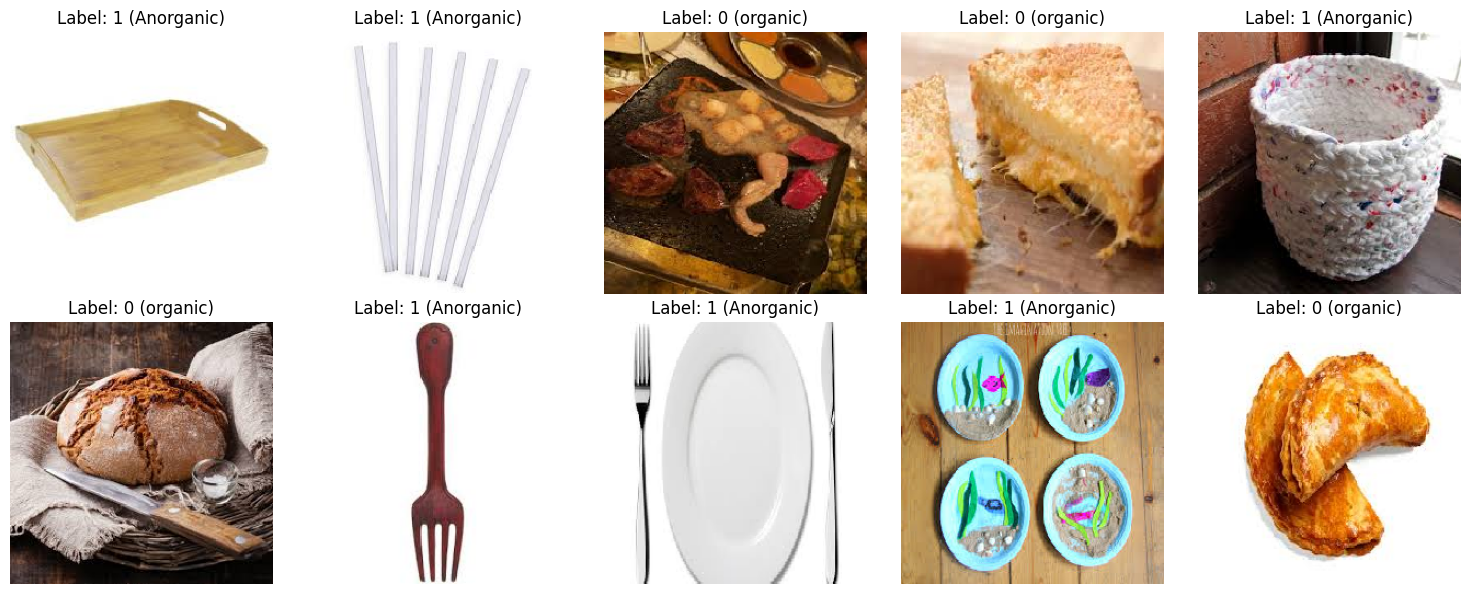

In [ ]:
from keras.preprocessing import image
import random

# Assuming 'path' column contains file paths and 'target' column contains numerical labels
random_sample_df = train_df.sample(10, random_state=42)  # Adjust the sample size as needed

# Create a subplot with 2 rows and 5 columns for better visualization
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

# Flatten the 2D array of axes for easier indexing
axes = axes.flatten()

# Mapping numerical labels to class names
label_mapping = {0: 'organic', 1: 'Anorganic'}

# Loop through the samples and display images with labels
for i, (index, row) in enumerate(random_sample_df.iterrows()):
    img_path = row['path']
    label = int(row['target'])  # Convert label to integer

    # Load and display the image
    img = image.load_img(img_path, target_size=(240, 240))
    axes[i].imshow(img)

    # Set the title with the corresponding label
    axes[i].set_title(f"Label: {label} ({label_mapping[label]})")

    # Remove the axis labels for clarity
    axes[i].axis('off')

plt.tight_layout()
plt.show()

## **BUILDING THE MODEL**

In [ ]:
# Defining callbacks

filepath = './final_model_weights.hdf5'

earlystopping = EarlyStopping(monitor = 'val_auc',
                              mode = 'max' ,
                              patience = 5,
                              verbose = 1)

checkpoint = ModelCheckpoint(filepath,
                                monitor = 'val_auc',
                                mode='max',
                                save_best_only=True,
                                verbose = 1)


callback_list = [earlystopping, checkpoint]

## **BASE MODEL (VGG16)**

In [ ]:
# Base model

base_model = VGG16(input_shape=(240,240,3),
                   include_top=False,
                   weights="imagenet")

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
# Freezing layers

for layer in base_model.layers:
    layer.trainable=False

In [ ]:
# Show vgg model summary
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 240, 240, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 240, 240, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 120, 120, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 120, 120, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 120, 120, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 60, 60, 128)       0     

## **VISUALIZING BASE MODEL LAYERS WITH TEST IMAGES**

block1_conv1
64


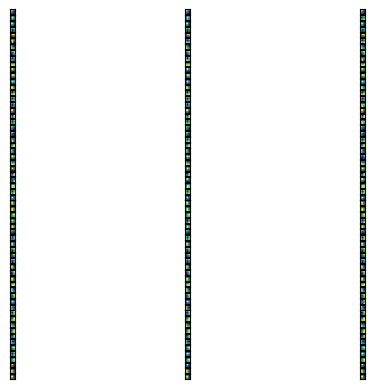

block1_conv2
64


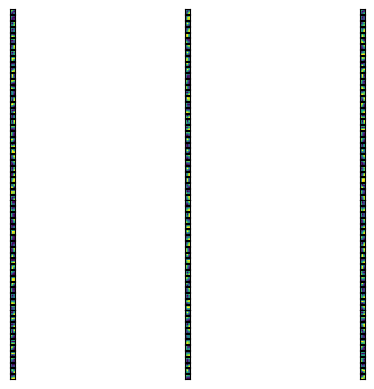

block2_conv1
128


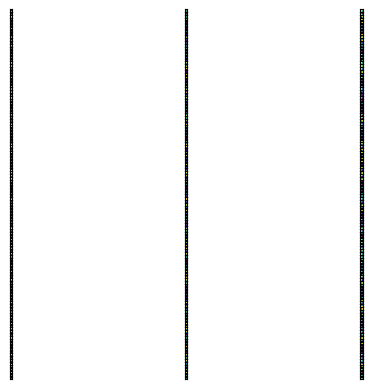

block2_conv2
128


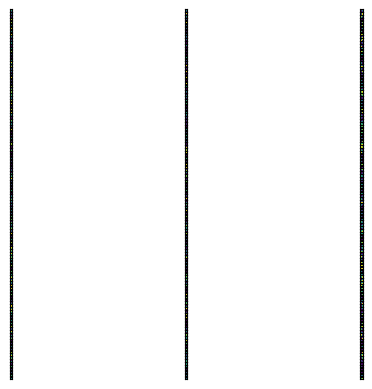

block3_conv1
256


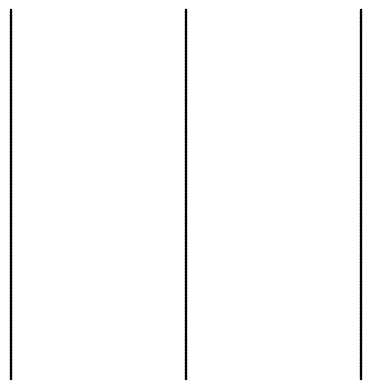

block3_conv2
256


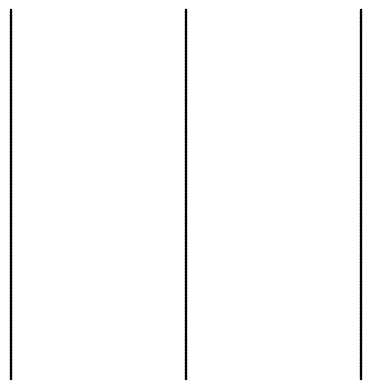

block3_conv3
256


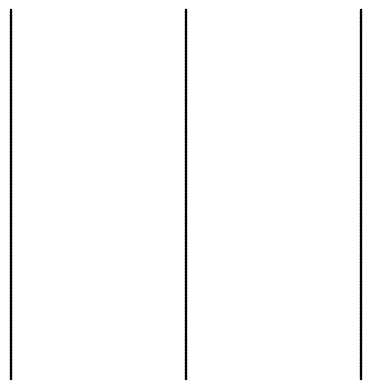

block4_conv1
512


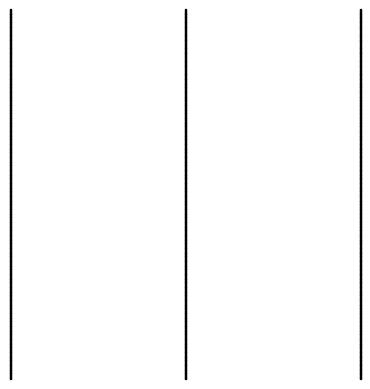

block4_conv2
512


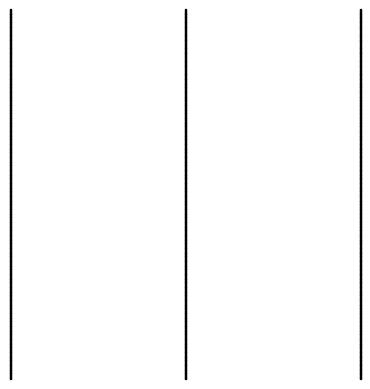

block4_conv3
512


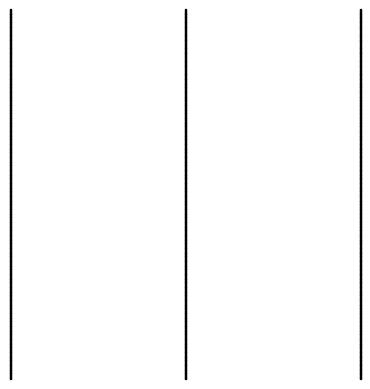

block5_conv1
512


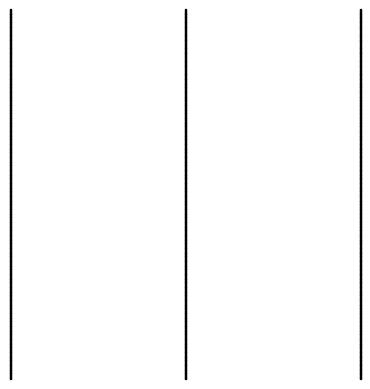

block5_conv2
512


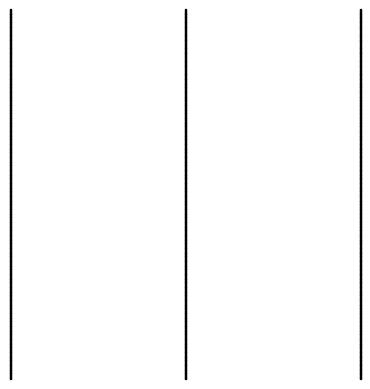

block5_conv3
512


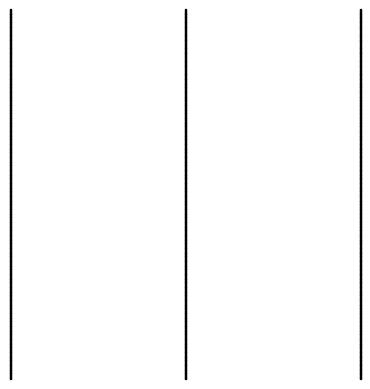

In [ ]:
# Iterate thru all the layers of the model

for layer in base_model.layers:
    if 'conv' in layer.name:
        weights, bias= layer.get_weights()
        # filters, biases = layer.get_weights()
        print(layer.name)
        # print(layer.name, filters.shape)
        # normalize filter values between  0 and 1 for visualization
        f_min, f_max = weights.min(), weights.max()
        filters = (weights - f_min) / (f_max - f_min)
        print(filters.shape[3])
        filter_cnt=1
        # plotting all the filters
        for i in range(filters.shape[3]):
            # get the filters
            filt=filters[:,:,:, i]
            # plotting each of the channel, color image RGB channels
            for j in range(filters.shape[0]):
                ax = plt.subplot(filters.shape[3], filters.shape[0], filter_cnt)
                ax.set_xticks([])
                ax.set_yticks([])
                plt.imshow(filt[:,:, j])
                filter_cnt+=1
        plt.show()

553467096/553467096 [==============================] - 6s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

<ipython-input-21-d726c6718322>:48: RuntimeWarning: invalid value encountered in divide
  x /= x.std()


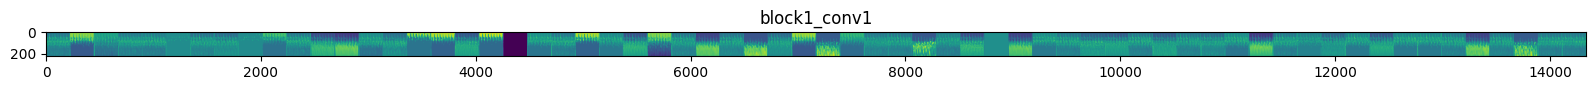

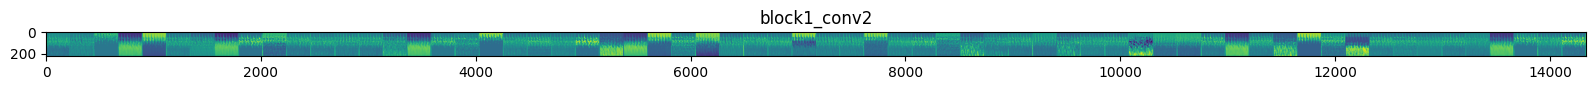

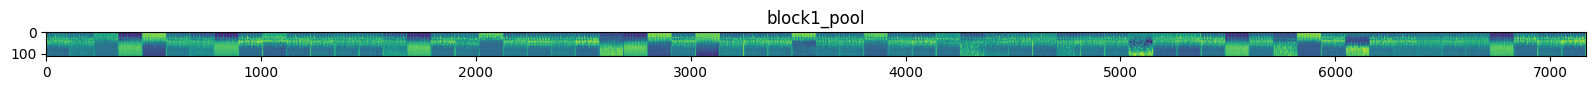

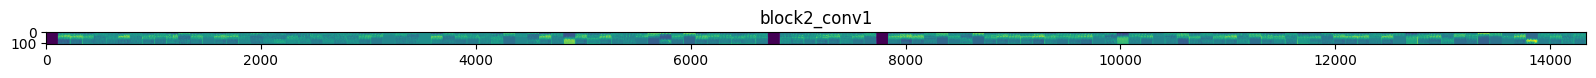

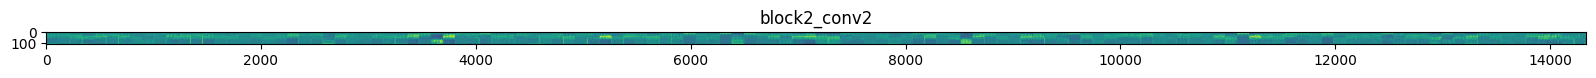

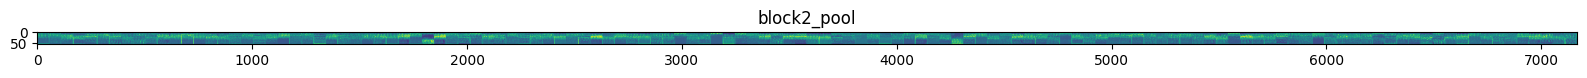

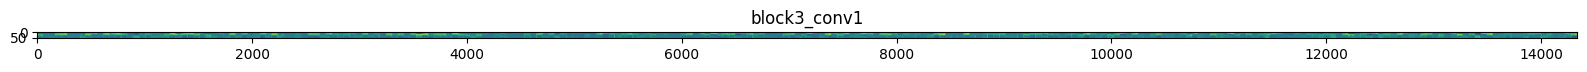

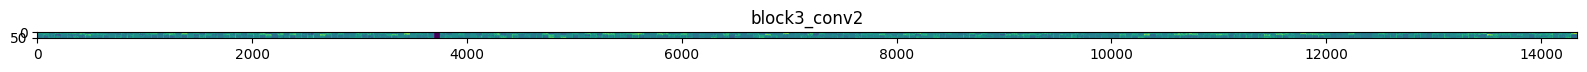

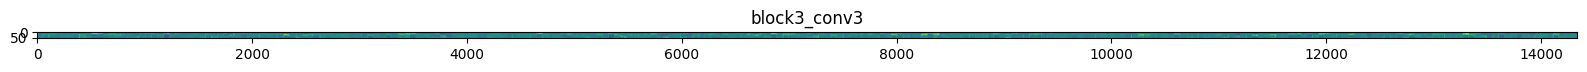

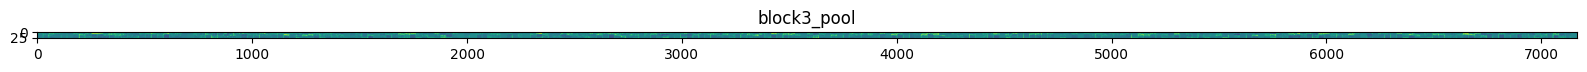

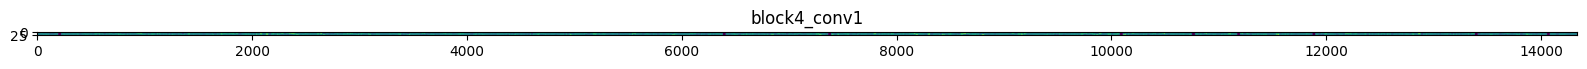

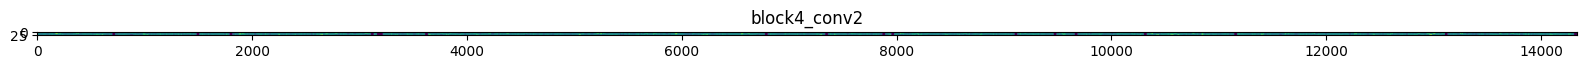

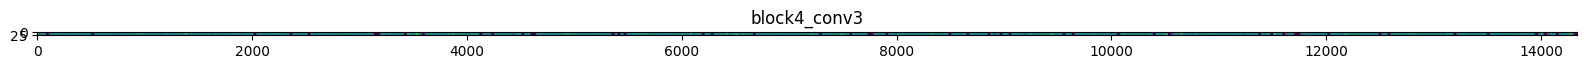

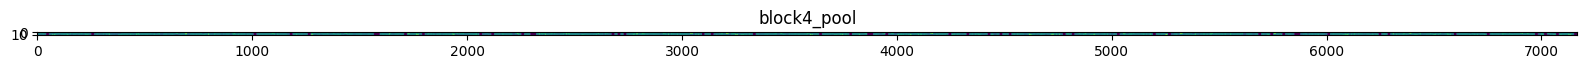

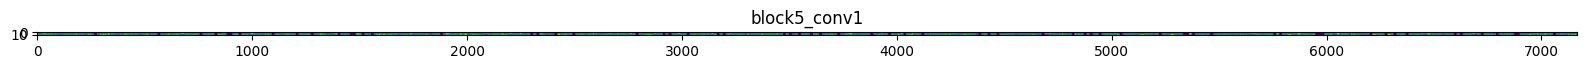

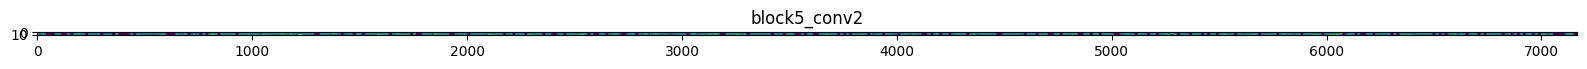

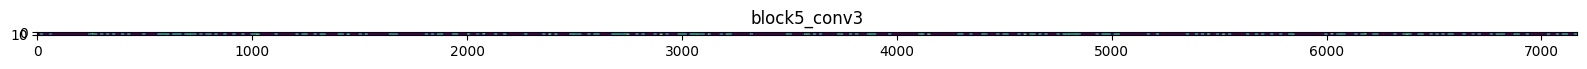

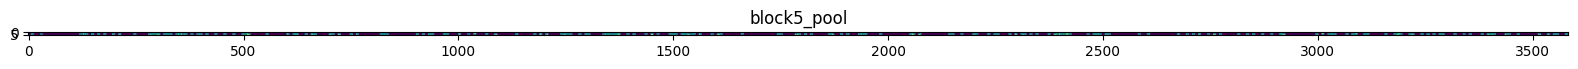

In [ ]:
from tensorflow.keras.models import Model
# Load pre-trained VGG16 model
base_model = VGG16(weights='imagenet')
base_model.summary()

# Choose an organic image for visualization from the training dataset
organic_images = train_df[train_df['target'] == '0']

if not organic_images.empty:
    # If there are organic images, sample 1
    organic_image_df = organic_images.sample(1, random_state=42)
    img_path = organic_image_df.iloc[0]['path']

    # Rest of your code for loading and visualizing the image
else:
    print("No organic images found in the training dataset.")


# Load the input image
img = load_img(img_path, target_size=(224, 224))  # VGG16 input size
x = img_to_array(img)
x = np.expand_dims(x, axis=0)
x = tf.keras.applications.vgg16.preprocess_input(x)

# Create a model that outputs the intermediate layers' activations
layer_outputs = [layer.output for layer in base_model.layers[1:]]  # Exclude the input layer
activation_model = Model(inputs=base_model.input, outputs=layer_outputs)

# Get the intermediate representations for the input image
activations = activation_model.predict(x)

# Extract layer names
layer_names = [layer.name for layer in base_model.layers[1:]]

# Display the feature maps
for layer_name, activation in zip(layer_names, activations):
    if len(activation.shape) == 4:  # Check if the layer has 4D tensor (batch_size, height, width, channels)
        n_features = activation.shape[-1]  # Number of features in the feature map
        size = activation.shape[1]  # Feature map shape (1, size, size, n_features)

        # Tile the activation channels in a matrix for better visualization
        display_grid = np.zeros((size, size * n_features))

        # Post-process the feature map to be visually palatable
        for i in range(n_features):
            x = activation[0, :, :, i]
            x -= x.mean()
            x /= x.std()
            x *= 64
            x += 128
            x = np.clip(x, 0, 255).astype('uint8')

            # Tile each filter into a horizontal grid
            display_grid[:, i * size: (i + 1) * size] = x

        # Display the grid
        scale = 20. / n_features
        plt.figure(figsize=(scale * n_features, scale))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, cmap='viridis')  # Choose a colormap (viridis, plasma, etc.)
        plt.show()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

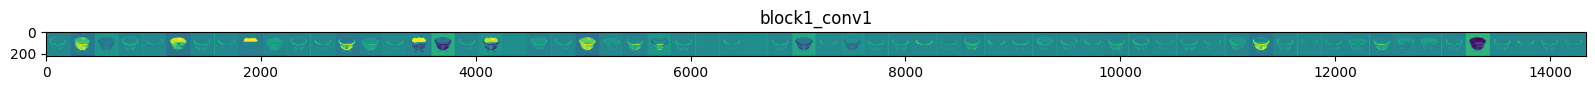

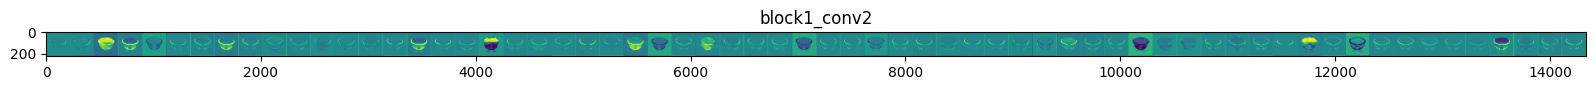

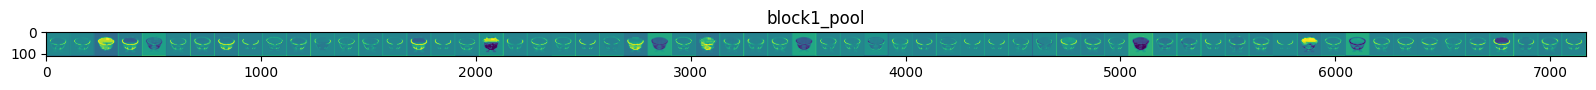

<ipython-input-22-388b8f7c0e4c>:45: RuntimeWarning: invalid value encountered in divide
  x /= x.std()


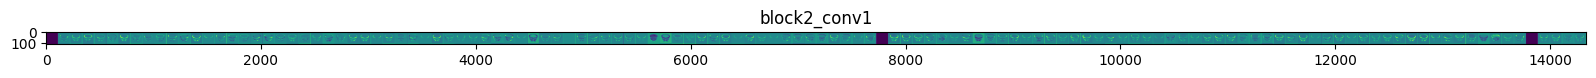

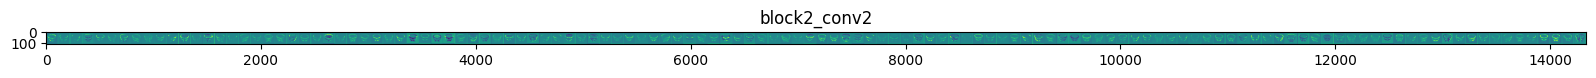

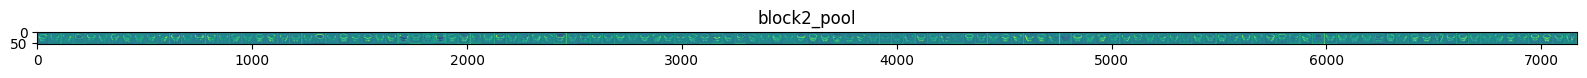

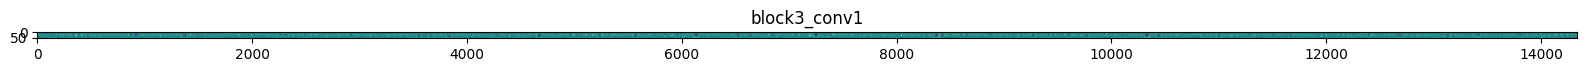

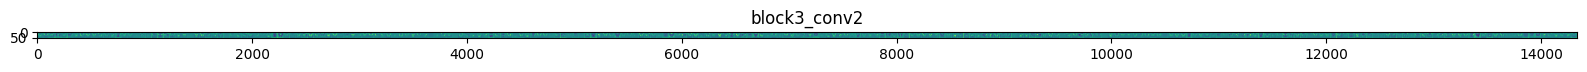

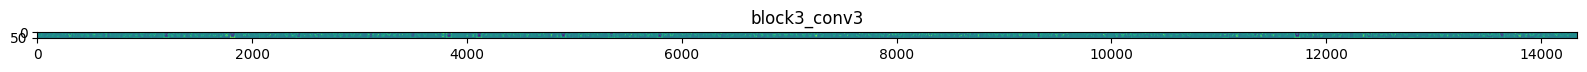

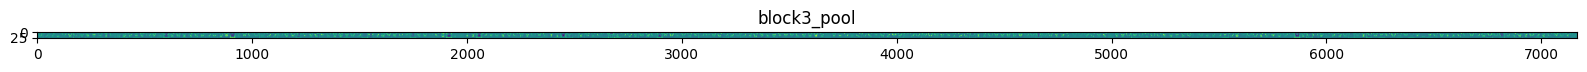

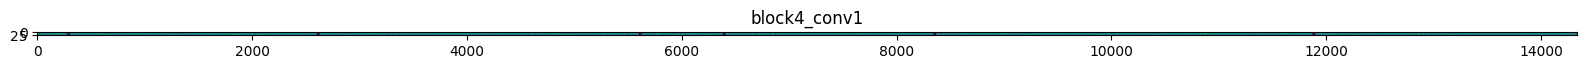

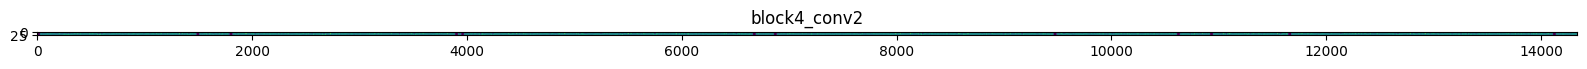

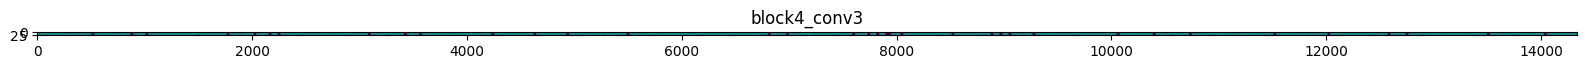

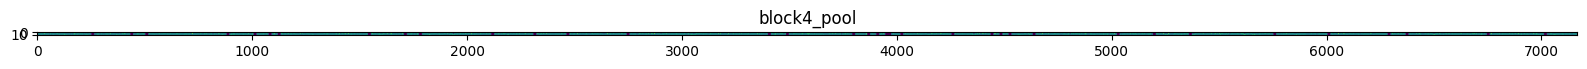

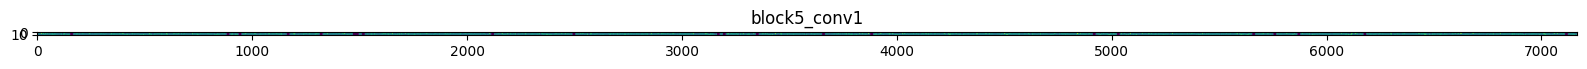

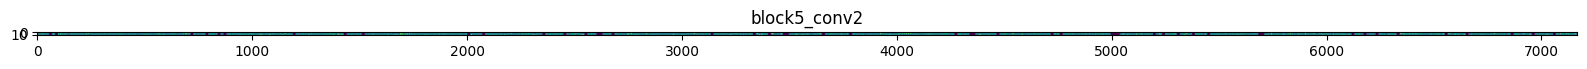

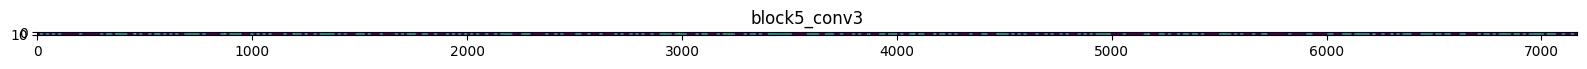

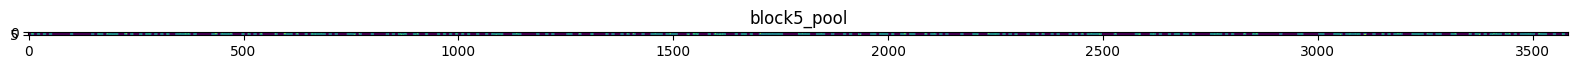

In [ ]:
# Load pre-trained VGG16 model
base_model = VGG16(weights='imagenet')
base_model.summary()

# Choose a anorganic image for visualization from the training dataset
anorganic_images = train_df[train_df['target'] == '1']

if not anorganic_images.empty:
    # If there are anorganic images, sample 1
    anorganic_image_df = anorganic_images.sample(1, random_state=42)
    img_path = anorganic_image_df.iloc[0]['path']

    # Rest of your code for loading and visualizing the image
else:
    print("No organic images found in the training dataset.")
# Load the input image
img = load_img(img_path, target_size=(224, 224))  # VGG16 input size
x = img_to_array(img)
x = np.expand_dims(x, axis=0)
x = tf.keras.applications.vgg16.preprocess_input(x)

# Create a model that outputs the intermediate layers' activations
layer_outputs = [layer.output for layer in base_model.layers[1:]]  # Exclude the input layer
activation_model = Model(inputs=base_model.input, outputs=layer_outputs)

# Get the intermediate representations for the input image
activations = activation_model.predict(x)

# Extract layer names
layer_names = [layer.name for layer in base_model.layers[1:]]

# Display the feature maps
for layer_name, activation in zip(layer_names, activations):
    if len(activation.shape) == 4:  # Check if the layer has 4D tensor (batch_size, height, width, channels)
        n_features = activation.shape[-1]  # Number of features in the feature map
        size = activation.shape[1]  # Feature map shape (1, size, size, n_features)

        # Tile the activation channels in a matrix for better visualization
        display_grid = np.zeros((size, size * n_features))

        # Post-process the feature map to be visually palatable
        for i in range(n_features):
            x = activation[0, :, :, i]
            x -= x.mean()
            x /= x.std()
            x *= 64
            x += 128
            x = np.clip(x, 0, 255).astype('uint8')

            # Tile each filter into a horizontal grid
            display_grid[:, i * size: (i + 1) * size] = x

        # Display the grid
        scale = 20. / n_features
        plt.figure(figsize=(scale * n_features, scale))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, cmap='viridis')  # Choose a colormap (viridis, plasma, etc.)
        plt.show()

## **MODEL TRAINING**

In [ ]:
num_classes = len(train_df['target'].unique())
num_classes

2

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input

# Assuming class_labels is the number of output classes
num_classes = len(class_labels)

# Load pre-trained MobileNetV3Large model
baseModel = MobileNetV3Large(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

# Freeze layers in the base model
for layer in baseModel.layers[:-6]:
    layer.trainable = False

# Add additional layers for classification
last_output = baseModel.layers[-1].output
x = tf.keras.layers.GlobalAveragePooling2D()(last_output)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(256, activation=tf.keras.activations.elu, kernel_regularizer=tf.keras.regularizers.l1(0.045), activity_regularizer=tf.keras.regularizers.l1(0.045), kernel_initializer='he_normal')(x)
x = tf.keras.layers.Dropout(0.45)(x)

# Output layer for classification with softmax activation
output_layer = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

# Create the model
model = tf.keras.Model(inputs=baseModel.input, outputs=output_layer)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00125),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

# Training configurations
epochs = 10
lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-3 * 10 ** (epoch / 30))
step_decay = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 0.1 * 0.1**math.floor(epoch / 6))

# Flow training images from DataFrame
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='path',
    y_col='target',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# Flow testing images from DataFrame
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='path',
    y_col='target',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# Train the model
history = model.fit(train_generator, validation_data=test_generator, epochs=epochs, callbacks=[lr_callback])

12683000/12683000 [==============================] - 0s 0us/step
Found 16300 validated image filenames belonging to 2 classes.
Found 8777 validated image filenames belonging to 2 classes.
Epoch 1/10
510/510 [==============================] - 1116s 2s/step - loss: 26.1396 - accuracy: 0.5833 - val_loss: 2.1123 - val_accuracy: 0.5591 - lr: 0.0010
Epoch 2/10
510/510 [==============================] - 1094s 2s/step - loss: 2.1364 - accuracy: 0.6042 - val_loss: 2.4342 - val_accuracy: 0.5588 - lr: 0.0011
Epoch 3/10
510/510 [==============================] - 1088s 2s/step - loss: 2.1646 - accuracy: 0.7000 - val_loss: 2.5622 - val_accuracy: 0.5586 - lr: 0.0012
Epoch 4/10
510/510 [==============================] - 1018s 2s/step - loss: 2.2348 - accuracy: 0.7153 - val_loss: 3.3644 - val_accuracy: 0.5586 - lr: 0.0013
Epoch 5/10
510/510 [==============================] - 1032s 2s/step - loss: 2.3192 - accuracy: 0.7254 - val_loss: 2.4603 - val_accuracy: 0.7080 - lr: 0.0014
Epoch 6/10
510/510 [======

In [ ]:
model.save("/content/model_35.h5")
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_4[0][0]']             
                                                                                                  
 Conv (Conv2D)               (None, 112, 112, 16)         432       ['rescaling[0][0]']           
                                                                                                  
 Conv/BatchNorm (BatchNorma  (None, 112, 112, 16)         64        ['Conv[0][0]']                
 lization)                                                                                  

In [ ]:
!ls /content/

Capstone_ML  history.csv  model_35.h5  model_35%.h5  sample_data


In [ ]:
from google.colab import files

files.download("model_35.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **MODEL EVALUATION**

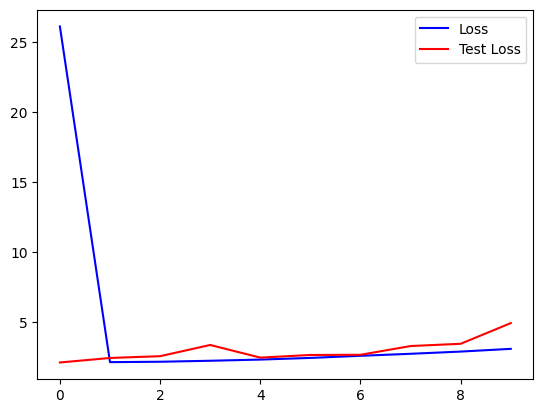

In [ ]:
plt.plot(range(0, epochs), history.history["loss"], color="b", label="Loss")
plt.plot(range(0, epochs), history.history["val_loss"], color="r", label="Test Loss")
plt.legend()
plt.show()

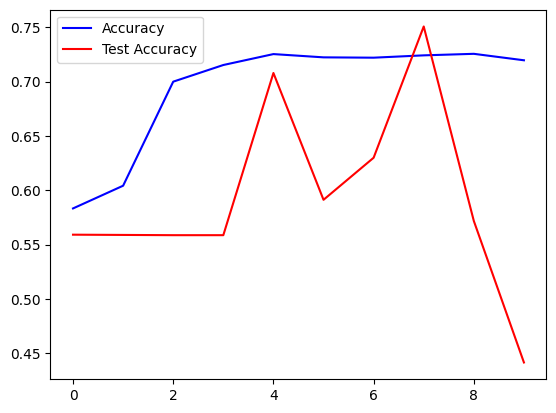

In [ ]:
plt.plot(range(0, epochs), history.history["accuracy"], color="b", label="Accuracy")
plt.plot(range(0, epochs), history.history["val_accuracy"], color="r", label="Test Accuracy")
plt.legend()
plt.show()

Text(0, 0.5, 'Loss')

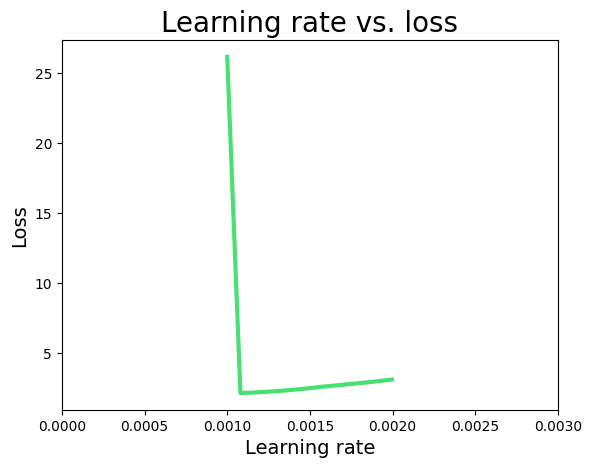

In [ ]:
plt.xlim([0, 0.003])
learning_rates = 1e-3 * (10 ** (np.arange(epochs) / 30))
plt.plot(learning_rates, history.history['loss'], lw=3, color='#48e073')
plt.title('Learning rate vs. loss', size=20)
plt.xlabel('Learning rate', size=14)
plt.ylabel('Loss', size=14)

In [ ]:
history_df = pd.DataFrame({
    'epoch': range(1, epochs + 1),
    'loss': history.history['loss'],
    'accuracy': history.history['accuracy'],
    'val_loss': history.history['val_loss'],
    'val_accuracy': history.history['val_accuracy']
})

# Save the DataFrame to a CSV file
history_df.to_csv('/content/history.csv', index=False)

# Display the DataFrame
history_df

epoch       loss  accuracy  val_loss  val_accuracy
0      1  26.139561  0.583252  2.112310      0.559075
1      2   2.136350  0.604172  2.434152      0.558847
2      3   2.164584  0.700000  2.562209      0.558619
3      4   2.234754  0.715337  3.364441      0.558619
4      5   2.319179  0.725399  2.460299      0.707987
5      6   2.438463  0.722393  2.649126      0.591204
6      7   2.590120  0.722086  2.661962      0.629942
7      8   2.733800  0.724233  3.287713      0.750826
8      9   2.891525  0.725644  3.449171      0.571722
9     10   3.087158  0.719693  4.928440      0.441381

## **CLASSIFICATION REPORT**

In [ ]:
from sklearn.metrics import classification_report

# Assuming you have already trained the model and have the test generator
# Make predictions on the test data
y_pred_probabilities = model.predict(test_generator)

# Convert probabilities to class labels
y_pred_labels = tf.argmax(y_pred_probabilities, axis=1)

# Get true labels from the generator
y_true_labels = test_generator.classes

# Decode class labels if your generator has class indices
class_labels = list(test_generator.class_indices.keys())
class_indices = test_generator.class_indices

# Generate classification report
report = classification_report(y_true_labels, y_pred_labels, target_names=class_labels)
print(report)

275/275 [==============================] - 266s 966ms/step
              precision    recall  f1-score   support

           0       1.00      0.00      0.00      4904
           1       0.44      1.00      0.61      3873

    accuracy                           0.44      8777
   macro avg       0.72      0.50      0.31      8777
weighted avg       0.75      0.44      0.27      8777



275/275 [==============================] - 267s 971ms/step


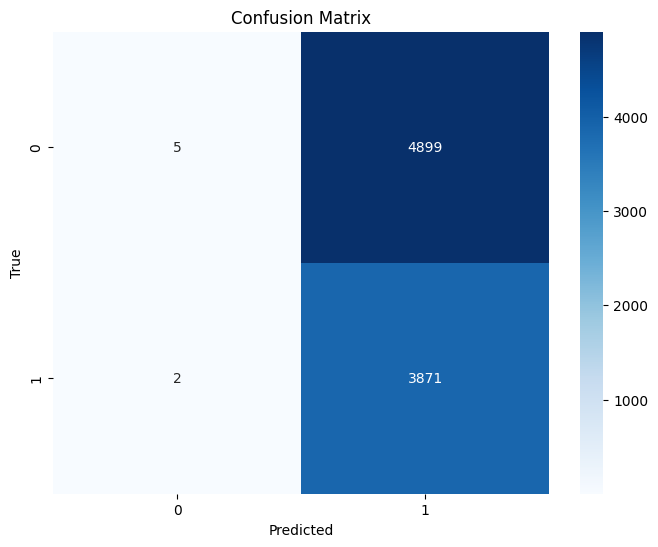

In [ ]:
# Make predictions on the test data
y_pred_probabilities = model.predict(test_generator)

# Convert probabilities to class labels
y_pred_labels = tf.argmax(y_pred_probabilities, axis=1)

# Get true labels from the generator
y_true_labels = test_generator.classes

# Decode class labels if your generator has class indices
class_labels = list(test_generator.class_indices.keys())
class_indices = test_generator.class_indices

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

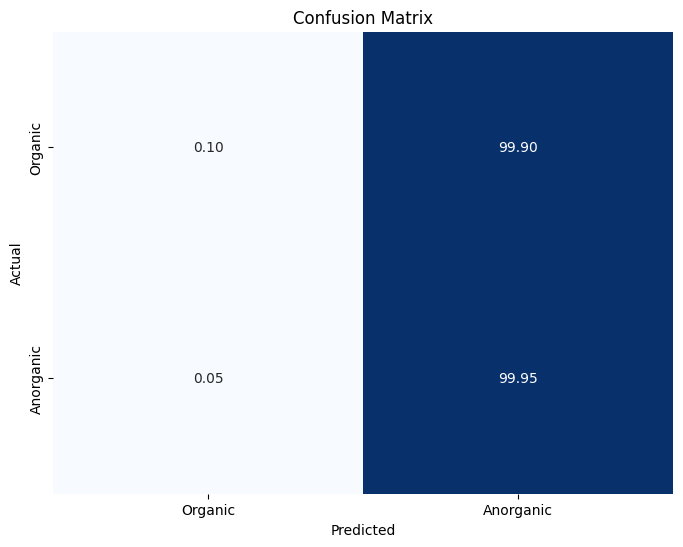

In [ ]:
conf_matrix = np.array([[5, 4899],
                        [2, 3871]])

# Calculate percentages
conf_matrix_percent = conf_matrix / np.sum(conf_matrix, axis=1, keepdims=True) * 100

# Create a Seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_percent, annot=True, fmt=".2f", cmap='Blues', cbar=False,
            xticklabels=['Organic', 'Anorganic'], yticklabels=['Organic', 'Anorganic'])

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## **PREDICTING TEST IMAGES**

In [ ]:
def getprediction(img):
    # Convert image to array and normalize pixel values
    img_array = img_to_array(img) / 255.0

    # Add batch dimension
    img_array = np.expand_dims(img_array, axis=0)

    # Make prediction
    prediction = model.predict(img_array)

    # Get predicted class and confidence
    predicted_class = np.argmax(prediction)
    confidence = prediction[0, predicted_class]

    # Display the prediction
    if predicted_class == 1:
        print(f"The image belongs to Recycle waste category, confidence: {confidence:.4f}.")
    else:
        print(f"The image belongs to Organic waste category, confidence: {confidence:.4f}.")

In [ ]:
def getprediction(img):
    img_array = img_to_array(img)
    img_array = img_array / 255.0  # Normalize pixel values to between 0 and 1
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction)
    confidence = prediction[0, predicted_class]

    if predicted_class == 1:
        print(f"The image belongs to Recycle waste category, confidence: {confidence:.4f}.")
    else:
        print(f"The image belongs to Organic waste category, confidence: {confidence:.4f}.")

Saving plastic4.jpg to plastic4.jpg
1/1 [==============================] - 1s 1s/step


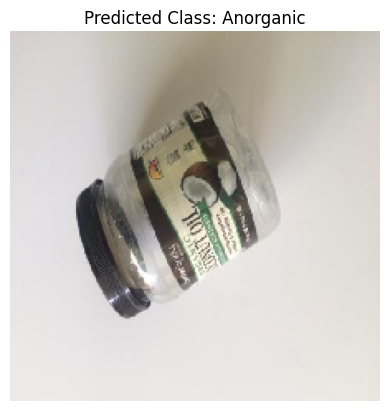

In [ ]:
from google.colab import files
from keras.preprocessing import image
import numpy as np

# Upload image files
uploaded = files.upload()

# Process and predict each uploaded image
for filename in uploaded.keys():
    # Load and resize the image to match the model's input size
    img_path = filename
    img = image.load_img(img_path, target_size=(224, 224))

    # Preprocess the image for the model prediction
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    # Use the model to make predictions
    predictions = model.predict(x)

    # Determine the predicted class
    predicted_class = np.argmax(predictions)
    class_label = "Anorganic" if predicted_class == 1 else "Organic"

    # Display the image and prediction result
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Predicted Class: {class_label}")
    plt.show()

Saving O_12568.jpg to O_12568.jpg
1/1 [==============================] - 0s 54ms/step


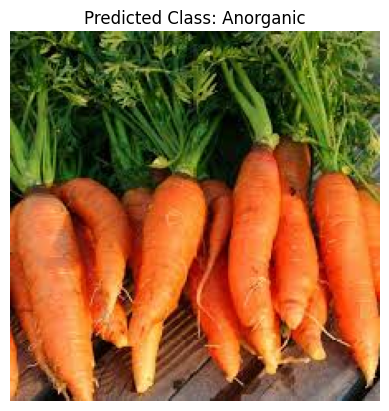

In [ ]:
from google.colab import files
from keras.preprocessing import image
import numpy as np

# Upload image files
uploaded = files.upload()

# Process and predict each uploaded image
for filename in uploaded.keys():
    # Load and resize the image to match the model's input size
    img_path = filename
    img = image.load_img(img_path, target_size=(224, 224))

    # Preprocess the image for the model prediction
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    # Use the model to make predictions
    predictions = model.predict(x)

    # Determine the predicted class
    predicted_class = np.argmax(predictions)
    class_label = "Anorganic" if predicted_class == 1 else "Organic"

    # Display the image and prediction result
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Predicted Class: {class_label}")
    plt.show()

Saving R_10012.jpg to R_10012.jpg
1/1 [==============================] - 0s 84ms/step


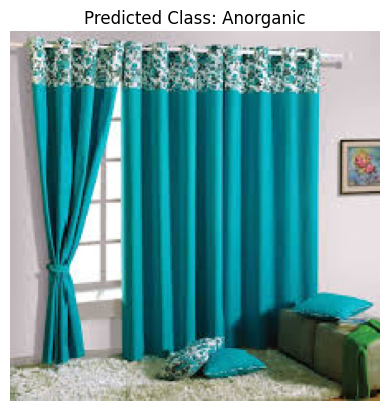

In [ ]:
from google.colab import files
from keras.preprocessing import image
import numpy as np

# Upload image files
uploaded = files.upload()

# Process and predict each uploaded image
for filename in uploaded.keys():
    # Load and resize the image to match the model's input size
    img_path = filename
    img = image.load_img(img_path, target_size=(224, 224))

    # Preprocess the image for the model prediction
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    # Use the model to make predictions
    predictions = model.predict(x)

    # Determine the predicted class
    predicted_class = np.argmax(predictions)
    class_label = "Anorganic" if predicted_class == 1 else "Organic"

    # Display the image and prediction result
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Predicted Class: {class_label}")
    plt.show()

Saving O_12571.jpg to O_12571.jpg
1/1 [==============================] - 0s 110ms/step


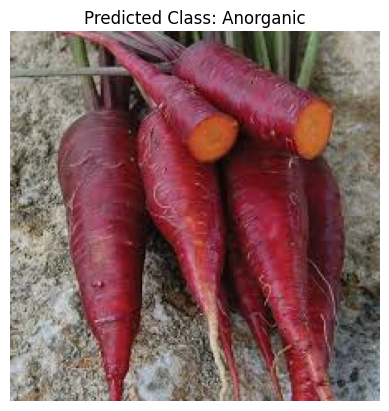

In [ ]:
from google.colab import files
from keras.preprocessing import image
import numpy as np

# Upload image files
uploaded = files.upload()

# Process and predict each uploaded image
for filename in uploaded.keys():
    # Load and resize the image to match the model's input size
    img_path = filename
    img = image.load_img(img_path, target_size=(224, 224))

    # Preprocess the image for the model prediction
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    # Use the model to make predictions
    predictions = model.predict(x)

    # Determine the predicted class
    predicted_class = np.argmax(predictions)
    class_label = "Anorganic" if predicted_class == 1 else "Organic"

    # Display the image and prediction result
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Predicted Class: {class_label}")
    plt.show()

Saving R_10594.jpg to R_10594.jpg
1/1 [==============================] - 0s 85ms/step


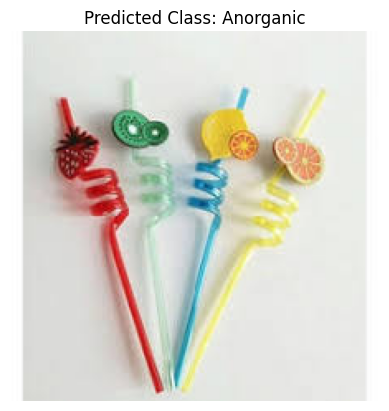

In [ ]:
from google.colab import files
from keras.preprocessing import image
import numpy as np

# Upload image files
uploaded = files.upload()

# Process and predict each uploaded image
for filename in uploaded.keys():
    # Load and resize the image to match the model's input size
    img_path = filename
    img = image.load_img(img_path, target_size=(224, 224))

    # Preprocess the image for the model prediction
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    # Use the model to make predictions
    predictions = model.predict(x)

    # Determine the predicted class
    predicted_class = np.argmax(predictions)
    class_label = "Anorganic" if predicted_class == 1 else "Organic"

    # Display the image and prediction result
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Predicted Class: {class_label}")
    plt.show()

Saving O_13369.jpg to O_13369.jpg
1/1 [==============================] - 0s 58ms/step


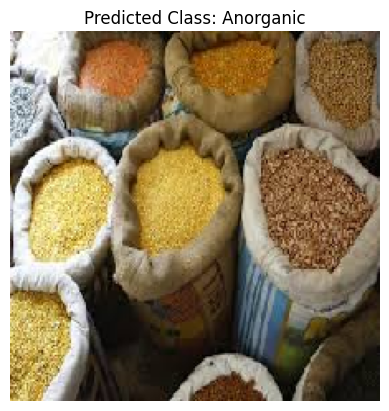

In [ ]:
from google.colab import files
from keras.preprocessing import image
import numpy as np

# Upload image files
uploaded = files.upload()

# Process and predict each uploaded image
for filename in uploaded.keys():
    # Load and resize the image to match the model's input size
    img_path = filename
    img = image.load_img(img_path, target_size=(224, 224))

    # Preprocess the image for the model prediction
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    # Use the model to make predictions
    predictions = model.predict(x)

    # Determine the predicted class
    predicted_class = np.argmax(predictions)
    class_label = "Anorganic" if predicted_class == 1 else "Organic"

    # Display the image and prediction result
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Predicted Class: {class_label}")
    plt.show()

Saving cardboard44.jpg to cardboard44.jpg
1/1 [==============================] - 0s 53ms/step


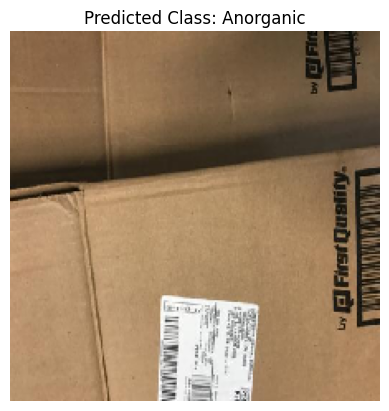

In [ ]:
from google.colab import files
from keras.preprocessing import image
import numpy as np

# Upload image files
uploaded = files.upload()

# Process and predict each uploaded image
for filename in uploaded.keys():
    # Load and resize the image to match the model's input size
    img_path = filename
    img = image.load_img(img_path, target_size=(224, 224))

    # Preprocess the image for the model prediction
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    # Use the model to make predictions
    predictions = model.predict(x)

    # Determine the predicted class
    predicted_class = np.argmax(predictions)
    class_label = "Anorganic" if predicted_class == 1 else "Organic"

    # Display the image and prediction result
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Predicted Class: {class_label}")
    plt.show()

Saving O_13966.jpg to O_13966.jpg
1/1 [==============================] - 0s 54ms/step


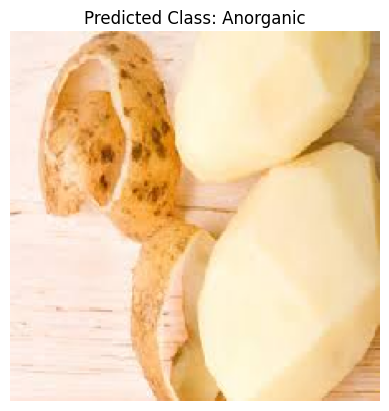

In [ ]:
from google.colab import files
from keras.preprocessing import image
import numpy as np

# Upload image files
uploaded = files.upload()

# Process and predict each uploaded image
for filename in uploaded.keys():
    # Load and resize the image to match the model's input size
    img_path = filename
    img = image.load_img(img_path, target_size=(224, 224))

    # Preprocess the image for the model prediction
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    # Use the model to make predictions
    predictions = model.predict(x)

    # Determine the predicted class
    predicted_class = np.argmax(predictions)
    class_label = "Anorganic" if predicted_class == 1 else "Organic"

    # Display the image and prediction result
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Predicted Class: {class_label}")
    plt.show()

Saving shoes1.jpg to shoes1.jpg
1/1 [==============================] - 0s 53ms/step


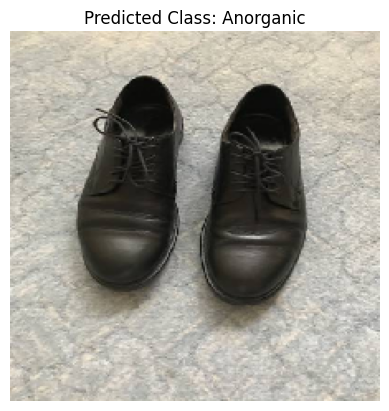

In [ ]:
from google.colab import files
from keras.preprocessing import image
import numpy as np

# Upload image files
uploaded = files.upload()

# Process and predict each uploaded image
for filename in uploaded.keys():
    # Load and resize the image to match the model's input size
    img_path = filename
    img = image.load_img(img_path, target_size=(224, 224))

    # Preprocess the image for the model prediction
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    # Use the model to make predictions
    predictions = model.predict(x)

    # Determine the predicted class
    predicted_class = np.argmax(predictions)
    class_label = "Anorganic" if predicted_class == 1 else "Organic"

    # Display the image and prediction result
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Predicted Class: {class_label}")
    plt.show()

Saving O_13190.jpg to O_13190.jpg
1/1 [==============================] - 0s 53ms/step


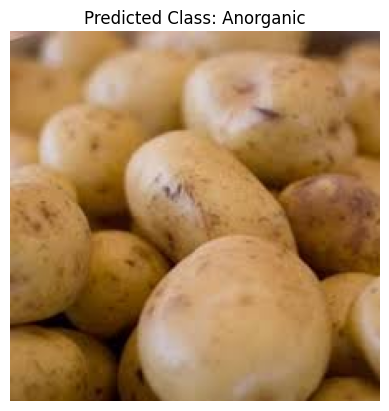

In [ ]:
from google.colab import files
from keras.preprocessing import image
import numpy as np

# Upload image files
uploaded = files.upload()

# Process and predict each uploaded image
for filename in uploaded.keys():
    # Load and resize the image to match the model's input size
    img_path = filename
    img = image.load_img(img_path, target_size=(224, 224))

    # Preprocess the image for the model prediction
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    # Use the model to make predictions
    predictions = model.predict(x)

    # Determine the predicted class
    predicted_class = np.argmax(predictions)
    class_label = "Anorganic" if predicted_class == 1 else "Organic"

    # Display the image and prediction result
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Predicted Class: {class_label}")
    plt.show()

In [ ]:
from google.colab import files
from keras.preprocessing import image
import numpy as np

# Upload image files
uploaded = files.upload()

# Process and predict each uploaded image
for filename in uploaded.keys():
    # Load and resize the image to match the model's input size
    img_path = filename
    img = image.load_img(img_path, target_size=(224, 224))

    # Preprocess the image for the model prediction
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    # Use the model to make predictions
    predictions = model.predict(x)

    # Determine the predicted class
    predicted_class = np.argmax(predictions)
    class_label = "Anorganic" if predicted_class == 1 else "Organic"

    # Display the image and prediction result
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Predicted Class: {class_label}")
    plt.show()

In [ ]:
from google.colab import files
from keras.preprocessing import image
import numpy as np

# Upload image files
uploaded = files.upload()

# Process and predict each uploaded image
for filename in uploaded.keys():
    # Load and resize the image to match the model's input size
    img_path = filename
    img = image.load_img(img_path, target_size=(224, 224))

    # Preprocess the image for the model prediction
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    # Use the model to make predictions
    predictions = model.predict(x)

    # Determine the predicted class
    predicted_class = np.argmax(predictions)
    class_label = "Anorganic" if predicted_class == 1 else "Organic"

    # Display the image and prediction result
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Predicted Class: {class_label}")
    plt.show()

In [ ]:
from google.colab import files
from keras.preprocessing import image
import numpy as np

# Upload image files
uploaded = files.upload()

# Process and predict each uploaded image
for filename in uploaded.keys():
    # Load and resize the image to match the model's input size
    img_path = filename
    img = image.load_img(img_path, target_size=(224, 224))

    # Preprocess the image for the model prediction
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    # Use the model to make predictions
    predictions = model.predict(x)

    # Determine the predicted class
    predicted_class = np.argmax(predictions)
    class_label = "Anorganic" if predicted_class == 1 else "Organic"

    # Display the image and prediction result
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Predicted Class: {class_label}")
    plt.show()

In [ ]:
from google.colab import files
from keras.preprocessing import image
import numpy as np

# Upload image files
uploaded = files.upload()

# Process and predict each uploaded image
for filename in uploaded.keys():
    # Load and resize the image to match the model's input size
    img_path = filename
    img = image.load_img(img_path, target_size=(224, 224))

    # Preprocess the image for the model prediction
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    # Use the model to make predictions
    predictions = model.predict(x)

    # Determine the predicted class
    predicted_class = np.argmax(predictions)
    class_label = "Anorganic" if predicted_class == 1 else "Organic"

    # Display the image and prediction result
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Predicted Class: {class_label}")
    plt.show()

In [ ]:
from google.colab import files
from keras.preprocessing import image
import numpy as np

# Upload image files
uploaded = files.upload()

# Process and predict each uploaded image
for filename in uploaded.keys():
    # Load and resize the image to match the model's input size
    img_path = filename
    img = image.load_img(img_path, target_size=(224, 224))

    # Preprocess the image for the model prediction
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    # Use the model to make predictions
    predictions = model.predict(x)

    # Determine the predicted class
    predicted_class = np.argmax(predictions)
    class_label = "Anorganic" if predicted_class == 1 else "Organic"

    # Display the image and prediction result
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Predicted Class: {class_label}")
    plt.show()

In [ ]:
from google.colab import files
from keras.preprocessing import image
import numpy as np

# Upload image files
uploaded = files.upload()

# Process and predict each uploaded image
for filename in uploaded.keys():
    # Load and resize the image to match the model's input size
    img_path = filename
    img = image.load_img(img_path, target_size=(224, 224))

    # Preprocess the image for the model prediction
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    # Use the model to make predictions
    predictions = model.predict(x)

    # Determine the predicted class
    predicted_class = np.argmax(predictions)
    class_label = "Anorganic" if predicted_class == 1 else "Organic"

    # Display the image and prediction result
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Predicted Class: {class_label}")
    plt.show()

In [ ]:
from google.colab import files
from keras.preprocessing import image
import numpy as np

# Upload image files
uploaded = files.upload()

# Process and predict each uploaded image
for filename in uploaded.keys():
    # Load and resize the image to match the model's input size
    img_path = filename
    img = image.load_img(img_path, target_size=(224, 224))

    # Preprocess the image for the model prediction
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    # Use the model to make predictions
    predictions = model.predict(x)

    # Determine the predicted class
    predicted_class = np.argmax(predictions)
    class_label = "Anorganic" if predicted_class == 1 else "Organic"

    # Display the image and prediction result
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Predicted Class: {class_label}")
    plt.show()

In [ ]:
from google.colab import files
from keras.preprocessing import image
import numpy as np

# Upload image files
uploaded = files.upload()

# Process and predict each uploaded image
for filename in uploaded.keys():
    # Load and resize the image to match the model's input size
    img_path = filename
    img = image.load_img(img_path, target_size=(224, 224))

    # Preprocess the image for the model prediction
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    # Use the model to make predictions
    predictions = model.predict(x)

    # Determine the predicted class
    predicted_class = np.argmax(predictions)
    class_label = "Anorganic" if predicted_class == 1 else "Organic"

    # Display the image and prediction result
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Predicted Class: {class_label}")
    plt.show()

In [ ]:
from google.colab import files
from keras.preprocessing import image
import numpy as np

# Upload image files
uploaded = files.upload()

# Process and predict each uploaded image
for filename in uploaded.keys():
    # Load and resize the image to match the model's input size
    img_path = filename
    img = image.load_img(img_path, target_size=(224, 224))

    # Preprocess the image for the model prediction
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    # Use the model to make predictions
    predictions = model.predict(x)

    # Determine the predicted class
    predicted_class = np.argmax(predictions)
    class_label = "Anorganic" if predicted_class == 1 else "Organic"

    # Display the image and prediction result
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Predicted Class: {class_label}")
    plt.show()

In [ ]:
from google.colab import files
from keras.preprocessing import image
import numpy as np

# Upload image files
uploaded = files.upload()

# Process and predict each uploaded image
for filename in uploaded.keys():
    # Load and resize the image to match the model's input size
    img_path = filename
    img = image.load_img(img_path, target_size=(224, 224))

    # Preprocess the image for the model prediction
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    # Use the model to make predictions
    predictions = model.predict(x)

    # Determine the predicted class
    predicted_class = np.argmax(predictions)
    class_label = "Anorganic" if predicted_class == 1 else "Organic"

    # Display the image and prediction result
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Predicted Class: {class_label}")
    plt.show()

In [ ]:
from google.colab import files
from keras.preprocessing import image
import numpy as np

# Upload image files
uploaded = files.upload()

# Process and predict each uploaded image
for filename in uploaded.keys():
    # Load and resize the image to match the model's input size
    img_path = filename
    img = image.load_img(img_path, target_size=(224, 224))

    # Preprocess the image for the model prediction
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    # Use the model to make predictions
    predictions = model.predict(x)

    # Determine the predicted class
    predicted_class = np.argmax(predictions)
    class_label = "Anorganic" if predicted_class == 1 else "Organic"

    # Display the image and prediction result
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Predicted Class: {class_label}")
    plt.show()